In [65]:
import pandas as pd
import numpy as np
import math
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [66]:
# Carregar dataset
data = pd.read_csv(r"ml-100k\u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])
data = data.drop('timestamp', axis=1)
data.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [67]:
# Divisão dos dados
"""""
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
print(f"Tamanho do conjunto do dataset: {len(data)}")
print(f"Tamanho do conjunto de teste: {len(test_data)}")
print(f"Tamanho do conjunto de treino: {len(train_data)}")
"""""

'""\ntrain_data, test_data = train_test_split(data, test_size=0.2, random_state=42)\nprint(f"Tamanho do conjunto do dataset: {len(data)}")\nprint(f"Tamanho do conjunto de teste: {len(test_data)}")\nprint(f"Tamanho do conjunto de treino: {len(train_data)}")\n'

In [68]:
class Avaliacao:
    def __init__(self, usuario_id, filme_id, avaliacao):
        self.usuario = usuario_id - 1
        self.filme = filme_id - 1
        self.avaliacao = avaliacao
        
# Definição da classe MatrizSVD
"""
parametros:
regularizador = lambda
k = 6
taxa_aprendizado = l_rate = 0.0066
rank = variaveis latentes [10, 30, 50] 
"""
class MatrizSVD:
    def __init__(self, dados_treino, num_usuarios, num_filmes, regularizador, rank, taxa_aprendizado=0.066, tipo_arquivo=0):
        self.avaliacoes_treino = []
        self.avaliacoes_teste = []
        self.num_usuarios = num_usuarios
        self.num_filmes = num_filmes

        if tipo_arquivo == 0:
            self.ler_treino(dados_treino)
        elif tipo_arquivo == 1:
            self.ler_treino_grande(dados_treino)

        media = self.media_avaliacoes()
        valor_inicial = math.sqrt(media / rank)
        self.U = [[valor_inicial] * rank for _ in range(num_usuarios)]
        self.V = [[valor_inicial] * rank for _ in range(num_filmes)]
        self.rank = rank
        self.taxa_aprendizado = taxa_aprendizado
        self.regularizador = regularizador
        self.minimo_melhoria = 0.001
        self.max_epocas = 30

    def produto_escalar(self, v1, v2):
        return sum([v1[i] * v2[i] for i in range(len(v1))])

    def calcular_avaliacao(self, usuario_id, filme_id):
        p = self.produto_escalar(self.U[usuario_id], self.V[filme_id])
        return max(1, min(p, 5))

    def media_avaliacoes(self):
        soma = sum(av.avaliacao for av in self.avaliacoes_treino)
        return soma / len(self.avaliacoes_treino)

    def prever(self, usuario_id, filme_id):
        return self.calcular_avaliacao(usuario_id, filme_id)

    def treinar(self, k):
        erro_quadratico_soma = 0
        for av in self.avaliacoes_treino:
            erro = av.avaliacao - self.prever(av.usuario, av.filme)
            erro_quadratico_soma += erro ** 2
            u_temp = self.U[av.usuario][k]
            v_temp = self.V[av.filme][k]
            self.U[av.usuario][k] += self.taxa_aprendizado * (erro * v_temp - self.regularizador * u_temp)
            self.V[av.filme][k] += self.taxa_aprendizado * (erro * u_temp - self.regularizador * v_temp)
        return math.sqrt(erro_quadratico_soma / len(self.avaliacoes_treino))

    def treinar_avaliacoes(self):
        erro_treino_antigo = 1e6
        for k in range(self.rank):
            for epoca in range(self.max_epocas):
                erro_treino = self.treinar(k)
                if abs(erro_treino_antigo - erro_treino) < self.minimo_melhoria:
                    break
                erro_treino_antigo = erro_treino

    def calcular_rmse(self, avaliacoes):
        erro_quadratico_soma = sum((av.avaliacao - self.calcular_avaliacao(av.usuario, av.filme)) ** 2 for av in avaliacoes)
        return math.sqrt(erro_quadratico_soma / len(avaliacoes))

    def calcular_mae(self, avaliacoes):
        erro_absoluto_soma = sum(abs(av.avaliacao - self.calcular_avaliacao(av.usuario, av.filme)) for av in avaliacoes)
        return erro_absoluto_soma / len(avaliacoes)

    def ler_avaliacoes(self, nome_arquivo, avaliacoes, delimitador="\t"):
        with open(nome_arquivo) as arquivo:
            for linha in arquivo:
                usuario_id, filme_id, avaliacao = map(int, linha.split(delimitador)[:3])
                avaliacoes.append(Avaliacao(usuario_id, filme_id, avaliacao))
        avaliacoes.sort(key=lambda av: (av.usuario, av.filme))

    def ler_treino(self, dados_treino):
        for row in dados_treino.itertuples():
            self.avaliacoes_treino.append(Avaliacao(row.user_id, row.item_id, row.rating))

    def ler_teste(self, dados_teste):
        for row in dados_teste.itertuples():
            self.avaliacoes_teste.append(Avaliacao(row.user_id, row.item_id, row.rating))



In [87]:
import timeit
num = 6
kf = KFold(n_splits=num)
mae_scores = []
rmse_scores = []
totmae_scores = []
totrmse_scores = []
latentes = [10, 30, 50] 
i = 0
for latente in latentes:
    start = timeit.default_timer()	
    for train_index, test_index in kf.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        i = i + 1
        svd = MatrizSVD(train_data, data['user_id'].nunique(), data['item_id'].nunique(),0.01,latente)
        svd.treinar_avaliacoes()
        svd.ler_teste(test_data)
        mae = svd.calcular_mae(svd.avaliacoes_teste)
        rmse = svd.calcular_rmse(svd.avaliacoes_teste)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
    totmae_scores.append(np.mean(mae_scores))
    totrmse_scores.append(np.mean(rmse_scores))
    stop = timeit.default_timer()
    print('Tempo: ', stop - start)
print("k =",num)
print("Média MAE:", np.mean(mae_scores))
print("Média RMSE:", np.mean(rmse_scores))

Tempo:  36.57132660003845
Tempo:  141.95781589997932
Tempo:  323.6718945999164
k = 6
Média MAE: 0.741108314291052
Média RMSE: 0.9462797275052066


[0.7607405397286022, 0.7586644755843405, 0.755929637570888, 0.7540321433948903, 0.753120001488013, 0.7522968972049577, 0.73878304814921, 0.7394530739015778, 0.739427530432814, 0.7278031660106224, 0.7306281644381146, 0.7339278966061759, 0.7353809759293857, 0.736271757414225, 0.7353589715958696, 0.7246791116189383, 0.7284646793265014, 0.7349875868438092]
[0.9692508220223656, 0.9655572386099602, 0.9629546021115521, 0.9564944379348207, 0.9539686986410205, 0.9528082344435355, 0.9470799757358193, 0.9482678091761865, 0.9460786650324482, 0.9306260871407328, 0.9306063159946226, 0.932446783135278, 0.9489582669401465, 0.9455370180194438, 0.9444545019926648, 0.9301358606606628, 0.9305596483104739, 0.9372501291919876]


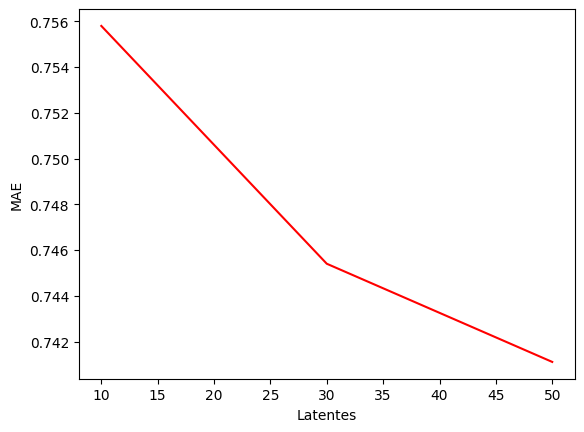

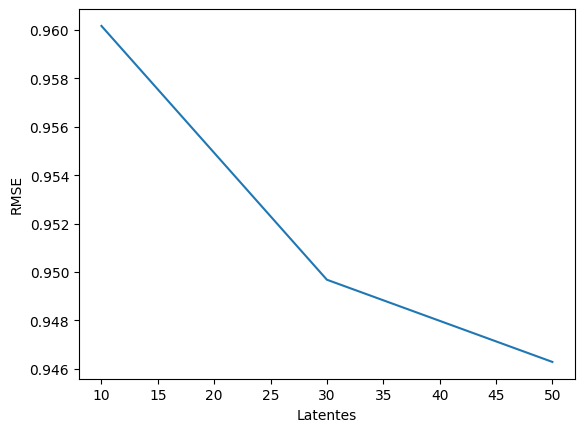

Text(0, 0.5, 'Tempo')

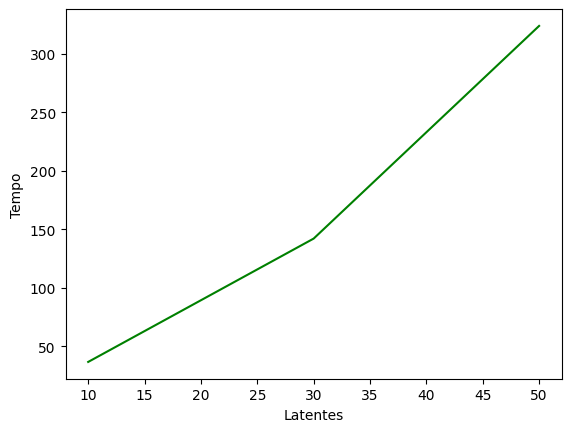

In [92]:
#verificação de quantidade de variáveis latentes
plt.plot(latentes, totmae_scores, label='MAE', color = 'red')
plt.xlabel('Latentes')
plt.ylabel('MAE')
plt.show()
plt.plot(latentes, totrmse_scores, label='RMSE')
plt.xlabel('Latentes')
plt.ylabel('RMSE')
plt.show()
plt.plot(latentes, tempos, label='Tempo', color = 'green')
plt.xlabel('Latentes')
plt.ylabel('Tempo')